
Original Data Summary:
Number of records: 324647
Number of columns: 11


Enter a capital city: London
Enter the current month (1-12): 12
Enter the current day (1-31): 31

Transformed Data Summary:
Number of records: 1
Number of columns: 6



Comparison for London in Month 12:
Historical Average Temp This Month: 6.18°C
Predicted Avg Temp for Today: 13.8°C
Data stored successfully.
Enter output format (csv/json): csv
Data saved to transformed_data.csv


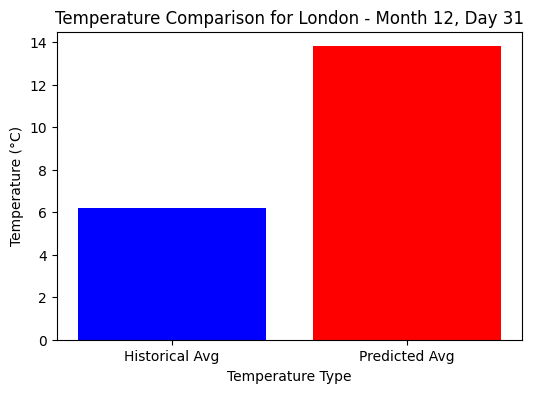

In [ ]:
import pandas as pd
import sqlite3
import requests
import datetime
import matplotlib.pyplot as plt
import json

def summarize_data(df, stage):
    print(f"\n{stage} Data Summary:")
    print(f"Number of records: {len(df)}")
    print(f"Number of columns: {len(df.columns)}")
    print("\n")

def load_historical_data(file_path):
#load csv
    if file_path.endswith(".csv"):
        df = pd.read_csv(file_path)
    elif file_path.endswith(".json"):
        df = pd.read_json(file_path)
    else:
        raise ValueError("Unsupported file format. Use CSV or JSON.")

    summarize_data(df, "Original")
    return df

def convert_file_format(df, output_format, output_path):
    if output_format == "csv":
        df.to_csv(output_path, index=False)
    elif output_format == "json":
        df.to_json(output_path, orient="records", indent=4)
    else:
        raise ValueError("Unsupported format. Use 'csv' or 'json'.")
    print(f"Data saved to {output_path}")

def get_historical_avg_temp(df, city, month, day):
    """
    Retrieves the historical average temperature for a specific city, month, and day
    across multiple years.
    """
    # Ensure 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

    # Extract month and day if not already extracted
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    # Filter data for the given city, month, and day
    city_data = df[(df['city'].str.lower() == city.lower()) &
                   (df['month'] == month) &
                   (df['day'] == day)]

    if city_data.empty:
        print(f"No historical data found for {city} on {month}/{day}.")
        return None

    # Compute and return the average temperature for that specific day across years
    return round(city_data['tavg'].mean(), 2)

def get_predicted_daily_temp(lat, lon):
#get daily average temp from API
    try:
        url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&daily=temperature_2m_max,temperature_2m_min&timezone=UTC"
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()

        if 'daily' in data:
            temp_max = data['daily']['temperature_2m_max']
            temp_min = data['daily']['temperature_2m_min']
            avg_predicted = round(sum(temp_max) / len(temp_max), 2)
            return avg_predicted
        else:
            print("Error: Missing 'daily' key in API response.")
            return None
    except requests.exceptions.RequestException as e:
        print(f"API Request Failed: {e}")
        return None

def modify_dataset(df, add_columns=None, remove_columns=None):
    if remove_columns:
        df = df.drop(columns=remove_columns, errors='ignore')

    if add_columns:
        for col, default_value in add_columns.items():
            df[col] = default_value

    return df

def store_in_database(city, month, day, hist_avg, pred_avg):
    conn = sqlite3.connect("weather_data.db")
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS temperature_comparison (
            city TEXT,
            month INTEGER,
            day INTEGER,
            historical_avg REAL,
            predicted_avg REAL,
            timestamp TEXT
        )
    """
    )
    cursor.execute("INSERT INTO temperature_comparison VALUES (?, ?, ?, ?, ?, ?)" ,
                   (city, month, day, hist_avg, pred_avg, datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
    conn.commit()
    conn.close()
    print("Data stored successfully.")


def visualize_comparison(city, month, day, hist_avg, pred_avg):
#show bar chart comparing historical average to this week's
    labels = ["Historical Avg", "Predicted Avg"]
    values = [hist_avg, pred_avg]

    plt.figure(figsize=(6,4))
    plt.bar(labels, values, color=['blue', 'red'])
    plt.xlabel("Temperature Type")
    plt.ylabel("Temperature (°C)")
    plt.title(f"Temperature Comparison for {city} - Month {month}, Day {day}")
    plt.show()

def main():
    file_path = "daily_weather_data.csv"
    df = load_historical_data(file_path)

    city = input("Enter a capital city: ")
    month = int(input("Enter the current month (1-12): "))
    day = int(input("Enter the current day (1-31): "))

    hist_avg_temp = get_historical_avg_temp(df, city, month, day)
    if hist_avg_temp is None:
        return

    # Get latitude and longitude from the dataset
    city_data = df[df['city'].str.lower() == city.lower()].iloc[0]
    lat = city_data['Latitude']
    lon = city_data['Longitude']

    pred_avg_temp = get_predicted_daily_temp(lat, lon)
    if pred_avg_temp is None:
        return

    transformed_df = pd.DataFrame({
        'city': [city],
        'month': [month],
        'day': [day],
        'historical_avg': [hist_avg_temp],
        'predicted_avg': [pred_avg_temp]
    })

    transformed_df = modify_dataset(transformed_df, add_columns={"prediction_accuracy": pred_avg_temp - hist_avg_temp})

    summarize_data(transformed_df, "Transformed")
    print(f"\nComparison for {city} in Month {month}:")
    print(f"Historical Average Temp This Month: {hist_avg_temp}°C")
    print(f"Predicted Avg Temp for Today: {pred_avg_temp}°C")

    # Store results in SQLite database
    store_in_database(city, month, day, hist_avg_temp, pred_avg_temp)

    output_format = input("Enter output format (csv/json): ")
    output_path = f"transformed_data.{output_format}"
    convert_file_format(transformed_df, output_format, output_path)

    # Visualize comparison
    visualize_comparison(city, month, day, hist_avg_temp, pred_avg_temp)

if __name__ == "__main__":
    main()